In [25]:
import sys
print(sys.executable)


c:\Users\aidou\anaconda3\envs\yoga-env\python.exe


# Business Understanding

The goal of this project is to classify yoga poses into categories using deep learning. 
Specifically, we want to analyze images of people performing yoga poses (e.g., downdog, goddess pose) 
and predict the correct pose category using three deep learning architectures:
- Two architectures built from scratch
- One pre-trained architecture (e.g., MobileNetV2)

We will evaluate the performance of these models to identify the best approach.


# Data Requirements & Data Collection

In [2]:
import os

# Dataset paths
train_dir = '../DATASET/TRAIN/'
test_dir = '../DATASET/TEST/'

# Check train subfolders
print("Train folders:", os.listdir(train_dir))
print("Test folders:", os.listdir(test_dir))

Train folders: ['downdog', 'goddess']
Test folders: ['downdog', 'goddess']


# Data Understanding & Preparation

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)
# Load data
train_data = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical'
)

val_data = val_test_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=False
)

test_data = val_test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=False
)

Found 401 images belonging to 2 classes.
Found 401 images belonging to 2 classes.
Found 174 images belonging to 2 classes.


c:\Users\aidou\anaconda3\envs\yoga-env\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


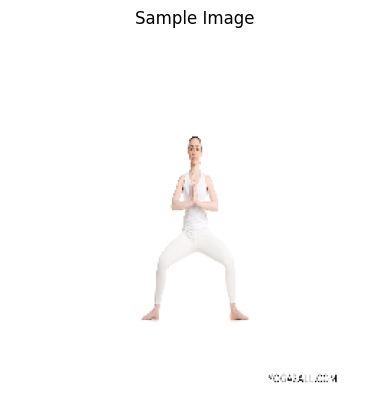

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
images, labels = next(train_data)  # Fetch the first batch from the generator

# Display the first image from the batch
plt.imshow((images[0] * 255).astype("uint8"))  # Scale back pixel values from 0-1 to 0-255
plt.title("Sample Image")
plt.axis("off")
plt.show()


In [5]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained DenseNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

# Combine base model with custom layers
model_densenet = Model(inputs=base_model.input, outputs=output)

# Unfreeze the last 20 layers for fine-tuning
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile the model
model_densenet.compile(
    optimizer=Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model_densenet.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


Epoch 1/10
 4/13 [========>.....................] - ETA: 8s - loss: 1.0387 - accuracy: 0.5703

c:\Users\aidou\anaconda3\envs\yoga-env\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


13/13 [==============================] - 34s 2s/step - loss: 0.7322 - accuracy: 0.7107 - val_loss: 0.2750 - val_accuracy: 0.9102
Epoch 2/10
13/13 [==============================] - 23s 2s/step - loss: 0.4681 - accuracy: 0.8229 - val_loss: 0.1076 - val_accuracy: 0.9676
Epoch 3/10
13/13 [==============================] - 22s 2s/step - loss: 0.2465 - accuracy: 0.8828 - val_loss: 0.0917 - val_accuracy: 0.9701
Epoch 4/10
13/13 [==============================] - 22s 2s/step - loss: 0.2661 - accuracy: 0.9102 - val_loss: 0.1009 - val_accuracy: 0.9651
Epoch 5/10
13/13 [==============================] - 21s 2s/step - loss: 0.2226 - accuracy: 0.8928 - val_loss: 0.0700 - val_accuracy: 0.9701
Epoch 6/10
13/13 [==============================] - 20s 2s/step - loss: 0.1342 - accuracy: 0.9476 - val_loss: 0.0643 - val_accuracy: 0.9751
Epoch 7/10
13/13 [==============================] - 21s 2s/step - loss: 0.1364 - accuracy: 0.9501 - val_loss: 0.0596 - val_accuracy: 0.9751
Epoch 8/10
13/13 [=============

In [6]:
# Evaluate the model
test_loss, test_acc = model_densenet.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")


6/6 [==============================] - 5s 761ms/step - loss: 0.0258 - accuracy: 0.9885
Test Accuracy: 0.9885


6/6 [==============================] - 5s 781ms/step


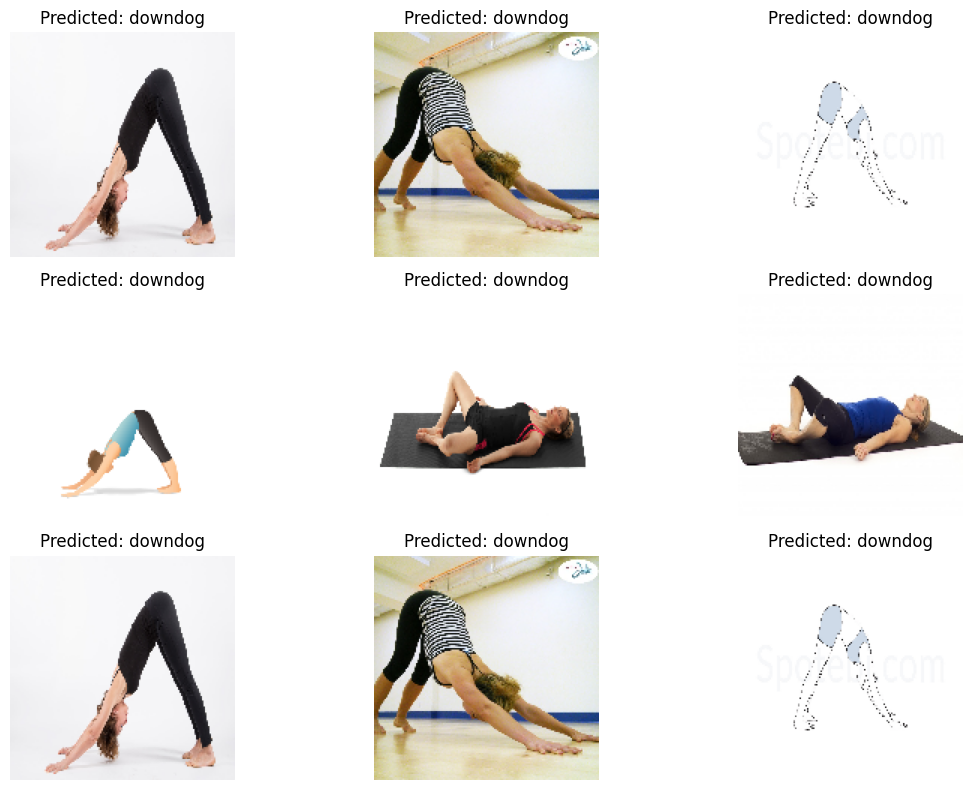

Image 1: Predicted Pose: downdog
------
Image 2: Predicted Pose: downdog
------
Image 3: Predicted Pose: downdog
------
Image 4: Predicted Pose: downdog
------
Image 5: Predicted Pose: downdog
------


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Predict on the test data
predictions = model_densenet.predict(test_data, verbose=1)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve class indices
class_indices = test_data.class_indices
class_names = list(class_indices.keys())

# Visualize predictions
plt.figure(figsize=(12, 8))

# Display the first 9 images with their predicted labels
for i, (img, label) in enumerate(test_data):  # Iterate over the test data batches
    if i == 9:  # Stop after 9 images
        break
    plt.subplot(3, 3, i + 1)
    plt.imshow(img[0])  # First image in the batch
    plt.title(f"Predicted: {class_names[predicted_classes[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print predictions for the first few images
for i in range(5):  # Example: print predictions for the first 5 images
    print(f"Image {i+1}: Predicted Pose: {class_names[predicted_classes[i]]}")
    print("------")


In [13]:
for i in range(5):  # Display confidence scores for first 5 images
    confidence_scores = predictions[i]
    predicted_label = class_names[predicted_classes[i]]
    print(f"Image {i+1}:")
    print(f"Predicted Pose: {predicted_label}")
    print(f"Confidence Scores: {confidence_scores}")
    print("------")


Image 1:
Predicted Pose: downdog
Confidence Scores: [9.9998164e-01 1.8353183e-05]
------
Image 2:
Predicted Pose: downdog
Confidence Scores: [9.9996924e-01 3.0797091e-05]
------
Image 3:
Predicted Pose: downdog
Confidence Scores: [9.999205e-01 7.945692e-05]
------
Image 4:
Predicted Pose: downdog
Confidence Scores: [9.9998915e-01 1.0805238e-05]
------
Image 5:
Predicted Pose: downdog
Confidence Scores: [9.9995136e-01 4.8657246e-05]
------


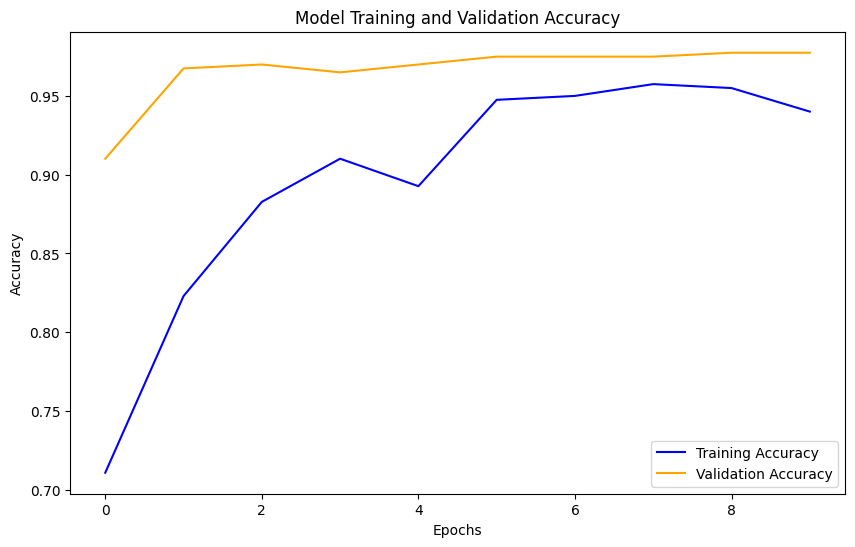

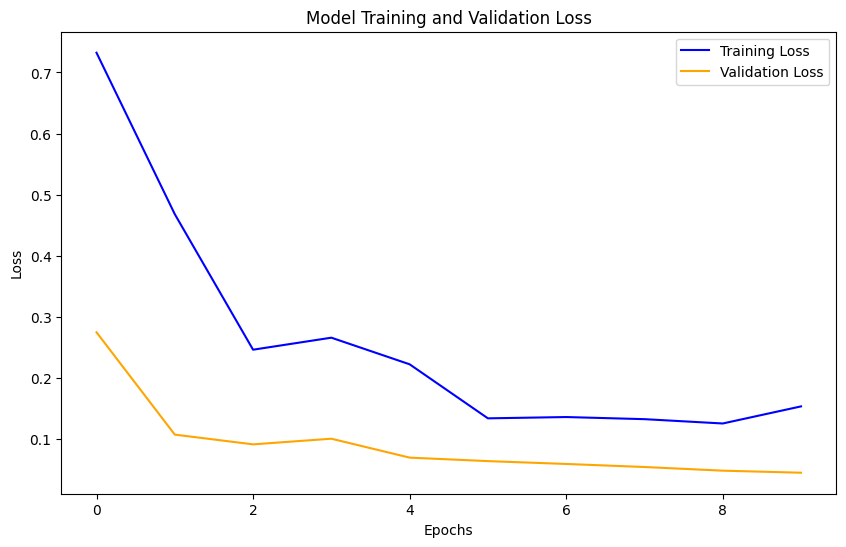

In [14]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title("Model Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Model Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Data Modeling

# MODEL 1 SIMPLE CNN

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

# First architecture (Simple CNN) without fixed input size
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(None, None, 3)),  # Dynamic input size
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),  # Replace Flatten with GAP to handle variable input sizes
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')  # Output layer
])

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history1 = model1.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
 4/13 [========>.....................] - ETA: 4s - loss: 0.6662 - accuracy: 0.6372

c:\Users\aidou\anaconda3\envs\yoga-env\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


13/13 [==============================] - 12s 855ms/step - loss: 0.6927 - accuracy: 0.5661 - val_loss: 0.6881 - val_accuracy: 0.5561
Epoch 2/10
13/13 [==============================] - 11s 881ms/step - loss: 0.6916 - accuracy: 0.5461 - val_loss: 0.6887 - val_accuracy: 0.5561
Epoch 3/10
13/13 [==============================] - 10s 816ms/step - loss: 0.6837 - accuracy: 0.5761 - val_loss: 0.6875 - val_accuracy: 0.5561
Epoch 4/10
13/13 [==============================] - 12s 905ms/step - loss: 0.6851 - accuracy: 0.5611 - val_loss: 0.6872 - val_accuracy: 0.5561
Epoch 5/10
13/13 [==============================] - 11s 818ms/step - loss: 0.6869 - accuracy: 0.5611 - val_loss: 0.6858 - val_accuracy: 0.5561
Epoch 6/10
13/13 [==============================] - 10s 793ms/step - loss: 0.6891 - accuracy: 0.5536 - val_loss: 0.6847 - val_accuracy: 0.5561
Epoch 7/10
13/13 [==============================] - 10s 775ms/step - loss: 0.6886 - accuracy: 0.5461 - val_loss: 0.6841 - val_accuracy: 0.5586
Epoch 8/10

# MODEL 2 ADVANCED CNN

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

# Advanced CNN model without fixed input size
model2 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(None, None, 3)),  # Dynamic input shape
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),  # Handles variable image dimensions
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')  # Output layer
])

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(train_data, validation_data=val_data, epochs=10)


Epoch 1/10
13/13 [==============================] - 19s 1s/step - loss: 0.7022 - accuracy: 0.5162 - val_loss: 0.6877 - val_accuracy: 0.5561
Epoch 2/10
13/13 [==============================] - 16s 1s/step - loss: 0.6918 - accuracy: 0.5387 - val_loss: 0.6871 - val_accuracy: 0.5561
Epoch 3/10
13/13 [==============================] - 15s 1s/step - loss: 0.6913 - accuracy: 0.5561 - val_loss: 0.6854 - val_accuracy: 0.5561
Epoch 4/10
13/13 [==============================] - 16s 1s/step - loss: 0.6850 - accuracy: 0.5561 - val_loss: 0.6773 - val_accuracy: 0.5561
Epoch 5/10
13/13 [==============================] - 16s 1s/step - loss: 0.6778 - accuracy: 0.5561 - val_loss: 0.6750 - val_accuracy: 0.5561
Epoch 6/10
13/13 [==============================] - 16s 1s/step - loss: 0.6815 - accuracy: 0.5561 - val_loss: 0.6758 - val_accuracy: 0.5561
Epoch 7/10
13/13 [==============================] - 16s 1s/step - loss: 0.6877 - accuracy: 0.5561 - val_loss: 0.6821 - val_accuracy: 0.5561
Epoch 8/10
13/13 [==

# MODEL 3 MOBILENETV2

In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Load the base MobileNetV2 model without resizing images
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(None, None, 3))
base_model.trainable = False  # Freeze the base model layers

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Handles variable image dimensions
x = Dense(128, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

# Create the model
model3 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model3.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
13/13 [==============================] - 14s 896ms/step - loss: 0.7395 - accuracy: 0.7456 - val_loss: 0.2873 - val_accuracy: 0.9152
Epoch 2/10
13/13 [==============================] - 10s 814ms/step - loss: 0.3106 - accuracy: 0.8953 - val_loss: 0.1606 - val_accuracy: 0.9426
Epoch 3/10
13/13 [==============================] - 10s 800ms/step - loss: 0.1802 - accuracy: 0.9352 - val_loss: 0.1620 - val_accuracy: 0.9277
Epoch 4/10
13/13 [==============================] - 11s 832ms/step - loss: 0.1835 - accuracy: 0.9352 - val_loss: 0.0937 - val_accuracy: 0.9601
Epoch 5/10
13/13 [==============================] - 10s 822ms/step - loss: 0.1200 - accuracy: 0.9601 - val_loss: 0.0726 - val_accuracy: 0.9751
Epoch 6/10
13/13 [==============================] - 10s 808ms/step - loss: 0.1188 - accuracy: 0.9576 - val_loss: 0.0685 - val_accuracy: 0.9701
Epoch 7/10
13/13 [==============================] - 10s 786ms/step - loss: 0.0907 - accuracy: 0.9651 - val_loss: 0.0601 - val_accuracy: 0.9800

# MODEL 4 DenseNet121

In [47]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load DenseNet121 without resizing input images
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(None, None, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Handle dynamic input sizes
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

# Combine base model with custom layers
model_densenet = Model(inputs=base_model.input, outputs=output)

# Freeze base model layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_densenet.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
11/11 [==============================] - 34s 3s/step - loss: 0.5952 - accuracy: 0.7174 - val_loss: 0.2698 - val_accuracy: 0.8734
Epoch 2/10
11/11 [==============================] - 28s 3s/step - loss: 0.2942 - accuracy: 0.8851 - val_loss: 0.2552 - val_accuracy: 0.8861
Epoch 3/10
11/11 [==============================] - 26s 2s/step - loss: 0.2264 - accuracy: 0.9099 - val_loss: 0.1393 - val_accuracy: 0.9747
Epoch 4/10
11/11 [==============================] - 26s 2s/step - loss: 0.1686 - accuracy: 0.9379 - val_loss: 0.1393 - val_accuracy: 0.9747
Epoch 5/10
11/11 [==============================] - 25s 2s/step - loss: 0.1035 - accuracy: 0.9689 - val_loss: 0.1109 - val_accuracy: 0.9747
Epoch 6/10
11/11 [==============================] - 25s 2s/step - loss: 0.0836 - accuracy: 0.9689 - val_loss: 0.0938 - val_accuracy: 0.9747
Epoch 7/10
11/11 [==============================] - 25s 2s/step - loss: 0.0684 - accuracy: 0.9845 - val_loss: 0.0923 - val_accuracy: 0.9747
Epoch 8/10
11/11 [==

# Model Evaluation

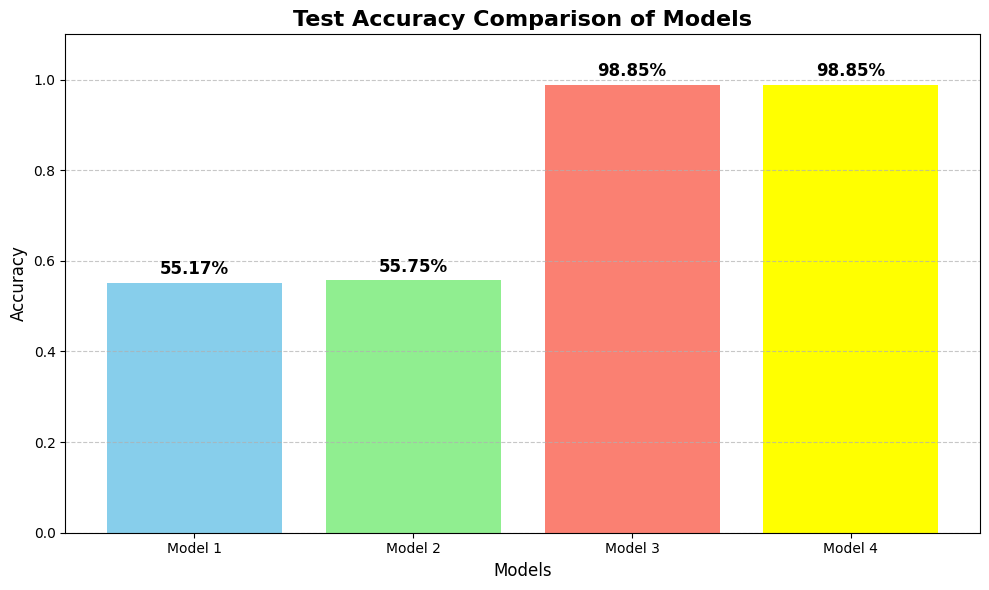

6/6 [==============================] - 3s 403ms/step - loss: 0.6898 - accuracy: 0.5517
Model 1 Accuracy: 0.5517241358757019
6/6 [==============================] - 3s 506ms/step - loss: 0.7007 - accuracy: 0.5575
Model 2 Accuracy: 0.5574712753295898
6/6 [==============================] - 4s 516ms/step - loss: 0.0412 - accuracy: 0.9885
Model 3 Accuracy: 0.9885057210922241
6/6 [==============================] - 6s 914ms/step - loss: 0.0258 - accuracy: 0.9885
Model 4 Accuracy: 0.9885057210922241


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate all models on the test data
model1_acc = model1.evaluate(test_data, verbose=0)[1]
model2_acc = model2.evaluate(test_data, verbose=0)[1]
model3_acc = model3.evaluate(test_data, verbose=0)[1]
model_densenet_acc = model_densenet.evaluate(test_data, verbose=0)[1]

# Accuracy values for visualization
accuracies = [model1_acc, model2_acc, model3_acc , model_densenet_acc]
models = ['Model 1', 'Model 2', 'Model 3' , 'Model 4']

# Plot the accuracies
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon','yellow'])

# Annotate the bars with accuracy values
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{acc:.2%}", 
             ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Add labels, title, and grid
plt.title("Test Accuracy Comparison of Models", fontsize=16, fontweight='bold')
plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.1)  # Extend Y-axis for visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
# Evaluate all models on the test data
print("Model 1 Accuracy:", model1.evaluate(test_data)[1])
print("Model 2 Accuracy:", model2.evaluate(test_data)[1])
print("Model 3 Accuracy:", model3.evaluate(test_data)[1])
print("Model 4 Accuracy:", model_densenet.evaluate(test_data)[1])



# MODELS PREDICTIONS 

6/6 [==============================] - 6s 961ms/step
Image 1:
Model 3 predicted pose: downdog
------
Image 2:
Model 3 predicted pose: downdog
------
Image 3:
Model 3 predicted pose: downdog
------
Image 4:
Model 3 predicted pose: downdog
------
Image 5:
Model 3 predicted pose: downdog
------


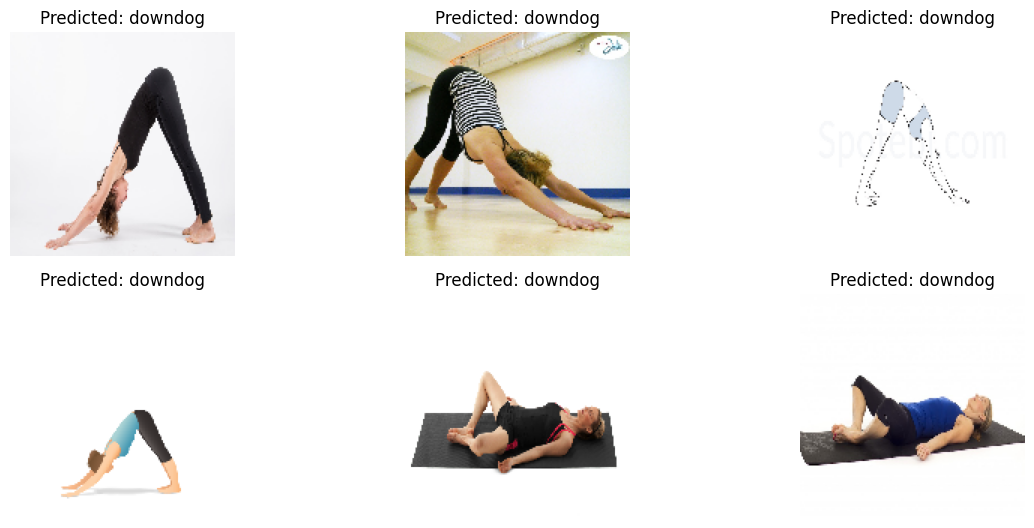

In [20]:
import numpy as np

# Get predictions for the new dataset using the trained models

predictions_model_densenet = model_densenet.predict(test_data, verbose=1)

# Convert predictions to class indices

predicted_classes_model_densenet = np.argmax(predictions_model_densenet, axis=1)

# Retrieve the class indices (pose names)
class_indices = list(test_data.class_indices.keys())

# Print predictions for the first few images
for i in range(5):  # Example: Print predictions for first 5 images
    print(f"Image {i+1}:")
    print(f"Model 3 predicted pose: {class_indices[predicted_classes_model_densenet[i]]}")
    print("------")
import matplotlib.pyplot as plt

# Visualize predictions
plt.figure(figsize=(12, 8))

# Display the first 9 images with their predicted labels
for i in range(min(9, len(test_data))):  # Display up to 9 images
    img, label = test_data[i]  # Get the i-th image and label from the batch
    plt.subplot(3, 3, i + 1)
    plt.imshow(img[0])  # Display the first image from the batch
    plt.title(f"Predicted: {class_indices[predicted_classes_model_densenet[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
